<a href="https://colab.research.google.com/github/Jeff-AB/ECE542FinalProject/blob/jeff-development/ECE542FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 542 Final Project

## How to Develop Code for the ECE 542 Final Project
We will be using jupyter notebooks and Google Codelabs to develop our image segmentation application. Each user will work from the same notebook using branches. Here is our strategy to use branches.

1.   Create a public github account(not a NCSU account). Request an invite to the repository from Jeff, and you will receive an email at the account linked to your github with an access link.

2.   Perform the following command to create a local repository on your computer

## Upload Rules
Upload your changes to your branch only. When you think that your changes are sufficient, make a pull request to the master branch from your personal branch and assign other members to review it. After a branch has been merged, everyone has to update their setups with the new master branch. You will be notified of this in the slack channel

# Notebook Settings
This section is used to put the notebook in Colab or local machine mode. It defines paths for each and optionally loads the zip file with the raw data if it does not already exist.

In [3]:
from os import path
import sys


# Google Colab or Local Notebook Settings
colab_notebook = False

data_dir = None
aug_data_dir = None

# Assign path variables
if colab_notebook:
    #Mount Google Drive Folder
    from google.colab import drive
    
    mount_dir = '/content/drive'
    drive.mount(mount_dir)
    
    data_dir = '/content/drive/My Drive/ECE 542 Final Project/data/bdd100k/seg/'
    aug_data_dir = '/content/drive/My Drive/ECE 542 Final Project/aug_data/'

    # Append local libraries
    MASK_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/Mask_RCNN/')
    CIT_ROOT = os.path.abspath('/content/drive/My Drive/ECE 542 Final Project/cityscapesScripts/')
    
    # Create Data Directory and extract zip file
    from os import path, mkdir
    import subprocess
    if not path.exists('/content/drive/My Drive/ECE 542 Final Project/data'):
        mkdir('/content/drive/My Drive/ECE 542 Final Project/data')
        subprocess.call(
            [
                'unzip', 
                '/content/drive/My Drive/ECE 542 Final Project/bdd100k_seg.zip', 
                '-d', 
                '/content/drive/My Drive/ECE 542 Final Project/data'
            ]
        )
        
else:
    data_dir = 'data/bdd100k/seg/'
    aug_data_dir = 'aug_data/'
    annotations_dir = 'data/bdd100k/labels/'
    
    # Append local libraries
    MASK_ROOT = os.path.abspath('Mask_RCNN/')
    CIT_ROOT = os.path.abspath('cityscapesScripts/')
    
    
if not path.exists(aug_data_dir):
    mkdir(aug_data_dir)
    mkdir(aug_data_dir + 'images')
    mkdir(aug_data_dir + 'labels')

try:
    import mcrnn
except:
    sys.path.append(MASK_ROOT)
    
    
try:
    import cityscapescripts
except:
    sys.path.append(CIT_ROOT)
    

# Data Preprocessing and Augmentation
This section preprocesses the data to have the correct shape and optionally augment it.

In [2]:
%matplotlib inline
# Data Augmentation Section
'''
This section contains the classes and functions needed to
augment the data for use with MaskRCNN
'''
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from os import listdir, walk
from os.path import isfile, join

from pprint import pprint
from matplotlib import pyplot as plt

import cv2
import random
import numpy as np
import gc

clpt = 'color_labels/train/'
clpv = 'color_labels/val/'

lpt = 'labels/train/'
lpv = 'labels/val/'

impt = 'images/train/'
impv = 'images/val/'

num_final_images = 40000 # 40K images to start
testing = True

class SegmentedDataAugmenter:
    '''
    Consumes 3GiB-5GiB of space while running
    '''
    def __init__(self, pair_list, num_images_desired, batch_size=32):
        self.num_images = num_images_desired
        self.raw_image_pairs = []
        self.preprocessed_image_batch = []
        self.file_pairs = pair_list
        self.MaskRCNN_width = 1024
        self.MaskRCNN_height = 1024
        self.batch_size = batch_size

        # Dictionary of arguments for ImageDataGenerator
        self.augment_args = {
            'featurewise_center': False,
            'samplewise_center': False,
            'featurewise_std_normalization': False,
            'samplewise_std_normalization': False,
            'zca_whitening': False,
            'zca_epsilon': 1e-06,
            'rotation_range': 0.0,
            'width_shift_range': 0.0,
            'height_shift_range': 0.0,
            'brightness_range': None,
            'shear_range': 0.0,
            'zoom_range': 0.0,
            'channel_shift_range': 0.0,
            'fill_mode': 'nearest',
            'cval': 0.0,
            'horizontal_flip': False,
            'vertical_flip': False,
            'rescale': None,
        }
        self.augment_args = {
            'featurewise_center': False,
            'samplewise_center': False,
            'featurewise_std_normalization': False,
            'samplewise_std_normalization': False,
            'zca_whitening': False,
            'zca_epsilon': 1e-06,
            'rotation_range': 120,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'brightness_range': None,
            'shear_range': 0.0,
            'zoom_range': 0.0,
            'channel_shift_range': 0.0,
            'fill_mode': 'nearest',
            'cval': 0.0,
            'horizontal_flip': True,
            'vertical_flip': False,
            'rescale': None,
        }
        
        if num_images_desired < batch_size:
            raise Exception('Undefined behavior with batch size larger than total number of images')
                
    def load_images(self):
        # Generator function that returns list of label, image tuples 'batch_size' amount at a time
        '''
        Can optimize this by working a tuple of a numpy array rather than a list of image tuples and 
        combining load_images and preprocess_images. Leaving it this way in case we need access to the 
        raw images for whatever reason later.
        
        The generator here is used to limit the number of images in memory at a time. Once the images
        this function yields are dereferenced, the memory is freed by Python's garbage collector.
        '''
        reducing_file_list = self.file_pairs
        while self.batch_size < len(reducing_file_list):
            self.raw_image_pairs = [] #Dereference old images
            for label_file, image_file in reducing_file_list[:self.batch_size]:
                label_img = cv2.imread(label_file)
                image = cv2.imread(image_file)
                self.raw_image_pairs.append((label_img, image))
            reducing_file_list = reducing_file_list[self.batch_size:]
            yield self.raw_image_pairs
            
        self.raw_image_pairs = [] #Dereference old images
        for label_file, image_file in reducing_file_list[:self.batch_size]:
            label_img = cv2.imread(label_file)
            image = cv2.imread(image_file)
            self.raw_image_pairs.append((label_img, image))
        yield self.raw_image_pairs           
        
    def nodistort_resize_image(self, image):
        '''
        The idea here is to rescale the image then crop out the excess. We lose some information, but I think
        this will give better results than scaling down the image and padding the empty vertical space
        with zeros. We can test this if need be.
        '''
        goal_height = self.MaskRCNN_height
        goal_width = self.MaskRCNN_width
        img_shape = image.shape
        
        #Rescale image to eliminate all padding in final image
        scale_factor = goal_height / img_shape[0]
        dest_size = (int(img_shape[1] * scale_factor), int(img_shape[0] * scale_factor) )
        resized = cv2.resize(image, dest_size)
        
        #Horizonally crop new image
        img_shape = resized.shape
        del_width = img_shape[1] - goal_width 
        resized = resized[:,int(del_width/2):int(-del_width/2),:]
        return resized
    
    def preprocess_images(self):
        # Generator function that preprocesses x number of images at a time
        # It is done this way rather than using the preprocessor argument in ImageDataGenerator
        # so we can have the resized data available without augmentation
        for batch_list in self.load_images():
            self.preprocessed_image_batch = [] #Make preprocessed image batch accessible outside of the class
            for segmenting_pair in batch_list:
                label = self.nodistort_resize_image(segmenting_pair[0])
                image = self.nodistort_resize_image(segmenting_pair[1])
                self.preprocessed_image_batch.append((label, image))
            yield self.preprocessed_image_batch
    
    def process_images(self, save_dir_base=None):
        # Generator function that augments the data in batches or saves them to files
        
        # Calculate the number of times to cycle image generator for each preprocessed batch
        num_augment = int(self.num_images/len(self.file_pairs))
        
        if num_augment < 1:
            raise Exception('Too few images requested')

        for image_batch in self.preprocess_images():
            labels, images = map(list, zip(*image_batch))
            
            # Convert to numpy arrays
            images = np.array(images)
            labels = np.array(labels)
            
            # Use ImageDataGenerator to augment batch
            label_augment = ImageDataGenerator(**self.augment_args)
            image_augment = ImageDataGenerator(**self.augment_args)
            
            
            # We need to ensure that the seeds are the same so that the same transformations are applied
            seed = random.randint(0,65000)
            '''
            This is set up to generate a set number of augmented images for each batch of raw images such that raw images are
            equally represented in the augmented image data set
            '''
            aug_label_gen = label_augment.flow(x=labels, batch_size=self.batch_size, seed=seed) 
            aug_img_gen = image_augment.flow(x=images, batch_size=self.batch_size, seed=seed)
            
            for i in range(0, num_augment):
                label_batch = next(aug_label_gen)
                image_batch = next(aug_img_gen)
                yield (label_batch, image_batch)

def save_preprocessed_to_directory():
    pass

def save_augmented_to_directory(num_augmented_images):
    
    # Check if augmented data directory is empty
    # Assume correct subdirectories were made
    for dirpath, dirnames, filenames in walk(aug_data_dir):
        if filenames:
            raise Exception("Augmented data directory is not empty")


    # Generate File Lists from Training Directory
    color_labels_train = [ data_dir + clpt + cl for cl in listdir(data_dir + clpt) if isfile(join(data_dir + clpt, cl)) ] 
    images_train = [ data_dir + impt + img for img in listdir(data_dir + impt) if isfile(join(data_dir + impt, img)) ]

    # Images with label map pair have the same file prefix
    color_labels_train.sort()
    images_train.sort()

    data_pairs = list(zip(color_labels_train, images_train))
    image_augment = SegmentedDataAugmenter(data_pairs, num_augmented_images) 
    augmented_data_generator  = image_augment.process_images()
    
    label_path = aug_data_dir + 'labels/'
    image_path = aug_data_dir + 'images/'
    index = 0
    
    for label_batch, image_batch in augmented_data_generator:
        #Assume these tensors have the same shape
        for i in range(0,image_batch.shape[0]):
            label_file_name = label_path + 'label-' + str(index) + '.png'
            image_file_name = image_path + 'image-' + str(index) + '.png'
            index+=1
            
            Image.fromarray(image_batch[i].astype(np.uint8)).save(image_file_name)
            Image.fromarray(label_batch[i].astype(np.uint8)).save(label_file_name)
        # We need aggressive garbage collecting to keep from using all the memory
        gc.collect() # clean up after every batch

# Save augmented data
try:
    save_augmented_to_directory(10240)
except Exception as e: 
    print(e)
finally:
    gc.collect() # This should get rid of the dereferenced objects in the function
    

Using TensorFlow backend.


Augmented data directory is not empty


# Instance Mask Extraction
This section focuses on converting semantic segmentation labels into instance masks and storing them in a usable format

car


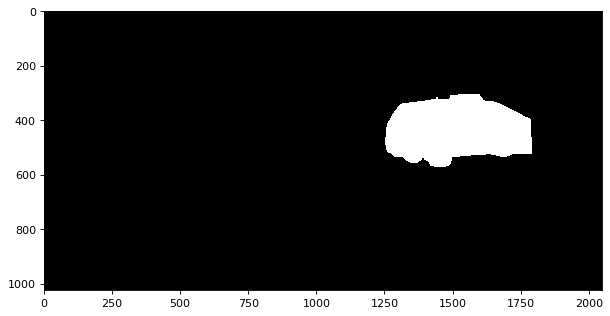

In [40]:
# Instance Mask Extraction
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import os
import random
    
from mrcnn.utils import Dataset
from cityscapesscripts.helpers.csHelpers import getCoreImageFileName

class CityscapesSegmentationDataset(Dataset):
    
    def load_cityscapes(self, root_directory, subset):
        if subset == 'train':
            self.data_dir = os.path.join(root_directory, 'train')
        elif subset == 'val':
            self.data_dir = os.path.join(root_directory, 'val')
        elif subset == 'test':
            self.data_dir = os.path.join(root_directory, 'test')
        else:
            raise Exception('No valid subset provided')
        
        # Create dictionary to house all files according to their image_id
        image_id_set = set()
        for root, dirs, filenames in os.walk(self.data_dir):
             for filename in filenames:
                image_id_set.add(getCoreImageFileName(filename))
        
        self._image_ids = list(image_id_set)
        #TODO Move remainder of annotation information to Dataset Class
        
    def load_mask(self, image_id):
        '''
        Loads mask corresponding to an image id
        
        image_id: the unique id of the form city_sequenceNb_frame_Nb
        
        returns a bool array of masks and a list of class ids
        The polygons are extracted from the json files and constructed into a binary image
        using PIL. 
        '''
        
        city = image_id.split('_')[0] # First element in list should be city
        annotation_path = os.path.join(os.path.join(self.data_dir, city), image_id + '_gtFine_polygons.json')
        ann_dict = {}
        
        with open(annotation_path) as annotation:
            ann_dict = json.load(annotation)
        masks = []
        class_ids = []
        
        for obj in ann_dict['objects']:
            class_ids.append(obj['label'])
            mask = Image.new(mode = '1', size = (ann_dict['imgWidth'], ann_dict['imgHeight']))
            draw = ImageDraw.Draw(mask)
            
            try:
                points = obj['polygon']
            except:
                print('no polygons for {}'.format(obj['label']))
            
            # PIL expects a tuple of tuples for points
            points = [tuple(coords) for coords in points]
            points = tuple(points)
            
            draw.polygon((points), fill=1)
            masks.append(mask)
        
        masks = np.stack(masks)
        return masks, class_ids
            
# Testing
csds = CityscapesSegmentationDataset()
csds.load_cityscapes('data/gtFine/', 'val')
masks, class_ids = csds.load_mask('frankfurt_000000_000294')
num_instances = len(class_ids)
select = random.randint(0,num_instances - 1)

print(class_ids[select])
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(np.asarray(masks[select]), cmap=plt.cm.gray)
